<a href="https://colab.research.google.com/github/daviddavini/math273a-final-project/blob/main/Teacher_Student_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28874490.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


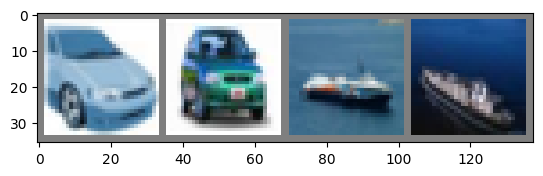

car   car   ship  ship 


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def layer1_output(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      return torch.flatten(x, 1)

    def layer2_output(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      return torch.flatten(x, 1)

    def layer3_output(self, x):
      x = self.layer2_output(x)
      x = F.relu(self.fc1(x))
      return x

    def layer4_output(self, x):
      x = self.layer3_output(x)
      x = F.relu(self.fc2(x))
      return x


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


teacher_net = Net()

In [32]:
class FCN(nn.Module):
  def __init__(self): # input_size, hidden_size, output_size
    super(FCN, self).__init__()
    self.layer1 = nn.Linear(3072, 2352) # Need to decide these sizes
    self.pool = nn.MaxPool2d(2, 2)
    self.layer2 = nn.Linear(2352, 400)
    self.layer3 = nn.Linear(400, 120)
    self.layer4 = nn.Linear(120, 84)
    self.layer5 = nn.Linear(84, 10)

  def layer1_output(self, x):
    x = torch.flatten(x, 1)
    return F.relu(self.layer1(x))

  def layer2_output(self, x):
    x = self.layer1_output(x)
    x = F.relu(self.layer2(x))
    return x

  def layer3_output(self, x):
    x = self.layer2_output(x)
    x = F.relu(self.layer3(x))
    return x

  def layer4_output(self, x):
    x = self.layer3_output(x)
    x = F.relu(self.layer4(x))
    return x


  def forward(self, x):
    x = self.layer4_output(x)
    x = self.layer5(x)
    return x

student_net = FCN()

In [7]:
student_net

FCN(
  (layer1): Linear(in_features=3072, out_features=2352, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Linear(in_features=2352, out_features=400, bias=True)
  (layer3): Linear(in_features=400, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (layer5): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
teacher_net

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
student_criterion = nn.MSELoss()
teacher_optimizer = optim.Adam(teacher_net.parameters(), lr=0.001)
student_optimizer = optim.Adam(student_net.parameters(), lr=0.01)

In [33]:
student_net.to(device)
teacher_net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
# Train teacher convolutional model
EPOCHS = 2
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        teacher_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacher_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        teacher_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.884
[1,  4000] loss: 1.607
[1,  6000] loss: 1.501
[1,  8000] loss: 1.465
[1, 10000] loss: 1.420
[1, 12000] loss: 1.379
[2,  2000] loss: 1.340
[2,  4000] loss: 1.292
[2,  6000] loss: 1.318
[2,  8000] loss: 1.289
[2, 10000] loss: 1.253
[2, 12000] loss: 1.264
Finished Training


In [14]:
# First layer training student from teacher
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        student_optimizer.zero_grad()

        # forward + backward + optimize
        teacher_outputs = teacher_net.layer1_output(inputs)
        student_outputs = student_net.layer1_output(inputs)
        loss = student_criterion(teacher_outputs, student_outputs)
        loss.backward()
        student_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i == 1:
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
student_net.layer1.weight.requires_grad = False # Lock layer 1's weights
student_net.layer1.bias.requires_grad = False

[1,     2] loss: 0.579
[1,  2000] loss: 0.190
[1,  4000] loss: 0.177
[1,  6000] loss: 0.182
[1,  8000] loss: 0.189
[1, 10000] loss: 0.189
[1, 12000] loss: 0.200
Finished Training


In [15]:
# Second layer training student from teacher
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[0].to(device)

        # zero the parameter gradients
        student_optimizer.zero_grad()

        # forward + backward + optimize
        teacher_outputs = teacher_net.layer2_output(inputs)
        student_outputs = student_net.layer2_output(inputs)
        loss = student_criterion(teacher_outputs, student_outputs)
        loss.backward()
        student_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
student_net.layer2.weight.requires_grad = False # Lock layer 2's weights
student_net.layer2.bias.requires_grad = False

[1,  2000] loss: 0.291
[1,  4000] loss: 0.244
[1,  6000] loss: 0.239
[1,  8000] loss: 0.237
[1, 10000] loss: 0.234
[1, 12000] loss: 0.240
Finished Training


In [48]:
# Run this
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        student_optimizer.zero_grad()

        # forward + backward + optimize
        teacher_outputs = teacher_net(inputs)
        student_outputs = student_net(inputs)
        loss = student_criterion(teacher_outputs, student_outputs)
        loss.backward()
        student_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 8.436
[1,  4000] loss: 8.137
[1,  6000] loss: 13.300
[1,  8000] loss: 8.239
[1, 10000] loss: 8.021
[1, 12000] loss: 8.099
Finished Training


In [20]:
# NOT THIS
student_criterion = nn.CrossEntropyLoss()
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        student_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = student_net(inputs)
        loss = student_criterion(outputs, labels)
        loss.backward()
        student_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.834
[1,  4000] loss: 1.826
[1,  6000] loss: 1.831
[1,  8000] loss: 1.824
[1, 10000] loss: 1.827
[1, 12000] loss: 1.842
Finished Training


In [35]:
PATH = './cifar_net.pth'
torch.save(teacher_net.state_dict(), PATH)

STUDENT_PATH = './cifar_student_net.pth'
torch.save(student_net.state_dict(), STUDENT_PATH)

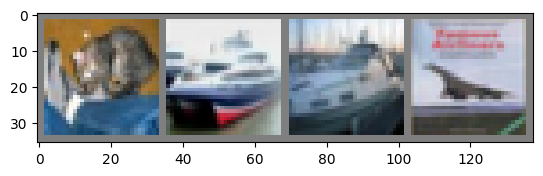

GroundTruth:  cat   ship  ship  plane


In [36]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [37]:
teacher_net = Net()
teacher_net.load_state_dict(torch.load(PATH))

outputs = teacher_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [38]:
outputs = teacher_net(images)
print(outputs)

student_net = FCN()
student_net.load_state_dict(torch.load(STUDENT_PATH))

outputs = student_net(images)
print(outputs)

tensor([[-0.9049, -1.6214, -1.5799,  0.5622, -2.3383, -1.4997, -2.5461, -2.2384,
         -0.5664, -1.2450],
        [ 2.1497,  1.5250, -6.6685, -8.3251, -6.7429, -9.0884, -9.8838, -9.1749,
          5.2274,  0.5500],
        [ 1.0028,  0.7385, -3.3424, -4.7913, -3.0565, -5.4310, -4.5628, -4.7778,
          2.1832,  0.1228],
        [ 2.3120, -0.5804, -2.0986, -4.4435, -0.8194, -5.3704, -4.5589, -4.6583,
          1.8583, -0.7142]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0705,  0.0252,  0.0905, -0.0463,  0.0936, -0.0549, -0.0219, -0.1161,
         -0.0688, -0.0083],
        [ 0.0732,  0.0339,  0.0823, -0.0476,  0.0923, -0.0493, -0.0241, -0.1107,
         -0.0813, -0.0078],
        [ 0.0735,  0.0277,  0.0821, -0.0494,  0.0883, -0.0463, -0.0217, -0.1033,
         -0.0809, -0.0079],
        [ 0.0726,  0.0264,  0.0868, -0.0445,  0.0891, -0.0429, -0.0329, -0.1111,
         -0.0699, -0.0013]], grad_fn=<AddmmBackward0>)


In [39]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  deer  deer  deer 


In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = teacher_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the teacher network on the 10000 test images: {100 * correct // total} %')

Accuracy of the teacher network on the 10000 test images: 53 %


In [23]:
student_net.to(device)

FCN(
  (layer1): Linear(in_features=3072, out_features=2352, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Linear(in_features=2352, out_features=400, bias=True)
  (layer3): Linear(in_features=400, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (layer5): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = student_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the student network on the 10000 test images: {100 * correct // total} %')

Accuracy of the student network on the 10000 test images: 45 %


In [26]:
teacher_net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
disagreements = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        student_outputs = student_net(images)
        teacher_outputs = teacher_net(images)
        # the class with the highest energy is what we choose as prediction
        _, student_predicted = torch.max(student_outputs.data, 1)
        _, teacher_predicted = torch.max(teacher_outputs.data, 1)
        total += labels.size(0)
        disagreements += (student_predicted == teacher_predicted).sum().item()

print(f'Percent of agreements between the student and teacher on the 10000 test images: {100 * disagreements / total} %')

Percent of agreements between the student and teacher on the 10000 test images: 61.19 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = teacher_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.3 %
Accuracy for class: car   is 72.0 %
Accuracy for class: bird  is 41.0 %
Accuracy for class: cat   is 31.5 %
Accuracy for class: deer  is 35.8 %
Accuracy for class: dog   is 68.4 %
Accuracy for class: frog  is 73.0 %
Accuracy for class: horse is 55.2 %
Accuracy for class: ship  is 68.1 %
Accuracy for class: truck is 60.2 %


In [55]:
# What about a low complexity student?
class baby_FCN(nn.Module):
  def __init__(self): # input_size, hidden_size, output_size
    super(baby_FCN, self).__init__()
    self.layer1 = nn.Linear(3072, 256) # Need to decide these sizes
    self.layer2 = nn.Linear(256, 128)
    self.layer3 = nn.Linear(128, 10)

  def layer1_output(self, x):
    x = torch.flatten(x, 1)
    return F.relu(self.layer1(x))

  def layer2_output(self, x):
    x = self.layer1_output(x)
    x = F.relu(self.layer2(x))
    return x

  def layer3_output(self, x):
    x = self.layer2_output(x)
    x = F.relu(self.layer3(x))
    return x


  def forward(self, x):
    x = self.layer3_output(x)
    return x

pre_school_net = baby_FCN()

In [58]:
pre_school_net.to(device)

baby_FCN(
  (layer1): Linear(in_features=3072, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)

In [61]:
# Run this
student_optimizer = torch.optim.Adam(pre_school_net.parameters(), lr=0.001)
student_criterion = nn.CrossEntropyLoss()
EPOCHS = 1
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        student_optimizer.zero_grad()

        # forward + backward + optimize
        teacher_outputs = teacher_net(inputs)
        student_outputs = pre_school_net(inputs)
        loss = student_criterion(teacher_outputs, student_outputs)
        loss.backward()
        student_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Finished Training


In [62]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = pre_school_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the baby student network on the 10000 test images: {100 * correct // total} %')

Accuracy of the baby student network on the 10000 test images: 10 %


In [48]:
plt.student_net.layer1.weight

Parameter containing:
tensor([[-0.0520, -0.0397, -0.0425,  ..., -0.0196, -0.0161,  0.0022],
        [-0.0491, -0.0286, -0.0433,  ..., -0.0266, -0.0245, -0.0179],
        [-0.0095, -0.0076, -0.0185,  ...,  0.0318,  0.0438,  0.0382],
        ...,
        [ 0.0097, -0.0036, -0.0175,  ..., -0.0186, -0.0143, -0.0266],
        [ 0.0422,  0.0244,  0.0122,  ..., -0.0308, -0.0449, -0.0139],
        [ 0.0195, -0.0169, -0.0315,  ..., -0.0447, -0.0406, -0.0205]],
       device='cuda:0', requires_grad=True)

In [28]:
import os
from matplotlib import pyplot as plt

def make_title(title, suffix):
    if suffix:
        title += " ({})".format(suffix)
    return title

def make_filename(name, suffix):
    filename = name
    if suffix:
        filename += "_{}".format(suffix)
    filename += ".svg"
    return filename

def plot_weights(net, name, suffix, save_dir):
    for i, layer in enumerate(net.linear_layers, 1):
        title = make_title("Weight matrix for layer {}".format(i), suffix)
        filename = make_filename("{}_layer_{}".format(name, i), suffix)
        plot_matrix(layer.weight, title, filename, save_dir)

def plot_data(X, name, suffix, save_dir):
    title = make_title("{} data".format(name), suffix)
    filename = make_filename(name, suffix)
    plot_matrix(X, title, filename, save_dir)

def plot_matrix(M, title, filename, save_dir):
    M = M.detach().cpu().numpy()
    plt.imshow(M, interpolation='nearest', aspect='auto')
    plt.colorbar()
    # Exclude titles from paper plots
    # plt.title(title)
    plt.savefig(os.path.join(save_dir, filename),bbox_inches='tight')
    plt.clf()

def plot_loss(train_losses, save_dir):
    plt.semilogy(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.savefig(os.path.join(save_dir, 'loss.svg'),bbox_inches='tight')
    plt.clf()

FileNotFoundError: ignored

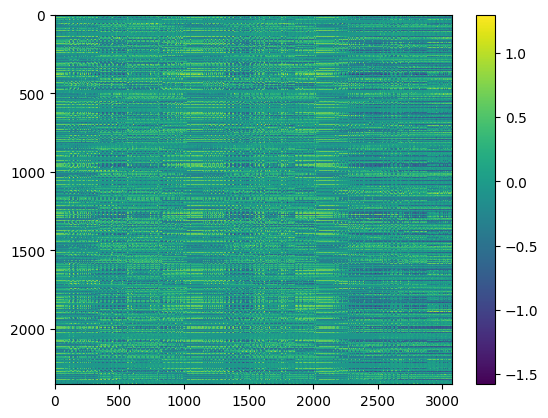

In [50]:
plot_matrix(student_net.layer1.weight, "Student Layer 1 Weights", "sl1w", "sl1w")